# Template Pipeline
Normalisation&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**-**  
Imputation 1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Outlier Detection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Z Score**  
Imputation 2&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Feature Selection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Implicit to model**  
Model&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Lasso Regression**


## Imports

In [ ]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ML
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge, LassoLarsCV, LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import FeatureAgglomeration

#from sklearn.preprocessing import StandardScaler

# Custom
import sys,os
sys.path.append('/home/jovyan/work/AML/Task_1/Solution') # I would like a cleaner solution but works for now
import Components.Imputation as Imputation
import Components.Outlier_Detection_1D as Outlier_Detection_1D
import Components.Outlier_Detection_ND as Outlier_Detection_ND
import Components.Feature_Selection as Feature_Selection
import Components.Normalisation as Normalisation
import Components.data_fetching as data_fetching

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(Imputation)
importlib.reload(Outlier_Detection_1D)
importlib.reload(Outlier_Detection_ND)
importlib.reload(Feature_Selection)
importlib.reload(Normalisation)
importlib.reload(data_fetching)

<module 'Components.data_fetching' from '/home/jovyan/work/AML/Task_1/Solution/Components/data_fetching.py'>

## Data Cleaning

### Data import

In [ ]:
x_train, y_train = data_fetching.get_train_data()
x_test = data_fetching.get_test_data()


### First (simple) imputation

In [ ]:
print("Missing values before simple median imputation: ")
print(x_train.isnull().sum().sum())
missing_values = Imputation.missing_values_mask(x_train)

x_train = Imputation.median(x_train, x_test)

print("Missing values after simple median imputation: ")
print(x_train.isnull().sum().sum())

Missing values before simple median imputation: 
76910
Missing values after simple median imputation: 
0


### Normalisation 

In [ ]:
x_train = Normalisation.gaussian(x_train)
x_test = Normalisation.gaussian(x_test)

### Outlier detection

one-dimensional

In [ ]:
x_train = Outlier_Detection_1D.z_score(x_train)

print("Missing values after outlier detection: ")
print(x_train.isnull().sum().sum())

X (1212, 832)
Missing values after outlier detection: 
1277


multivariate

In [ ]:
x_train, y_train, missing_values = Outlier_Detection_ND.magic_indices(x_train,y_train,n_outliers=100, mask=missing_values)
## hp

### Second (more sophisticated) Imputation

In [ ]:
x_train = x_train.mask(missing_values)
print("Missing values after applying the missing value mask: ")
print(x_train.isnull().sum().sum())

x_train, x_test = Imputation.iterative_regression2(x_train,x_test) #hp


print("Missing values after second round of imputation: ")
print(x_train.isnull().sum().sum())


Missing values after applying the missing value mask: 
71758
/opt/venv/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
Missing values after second round of imputation: 
0


## Feature selection and Model Training

In [ ]:


#pipe = Pipeline([('feature_selection', SelectFromModel(LassoLarsCV())),('regressor', AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
  #                        n_estimators=300))])

#pipe = Pipeline([('feature_selection1',SelectKBest(mutual_info_regression, k=200)),('feature_selection2', SelectFromModel(LassoLarsCV())),
#('regressor', GradientBoostingRegressor(n_estimators=100))])

# hp: which method to choose for feature selection and regression

In [ ]:
pipe = Pipeline([('feature_selection1',SelectKBest(mutual_info_regression, k=400)),
    ('dimensionality reduction', FeatureAgglomeration(n_clusters=100)),
    ('feature_selection2',SelectKBest(mutual_info_regression, k=40)),
    ('regressor', GradientBoostingRegressor(n_estimators=100))])

### Cross Validation

In [ ]:
scores = cross_val_score(pipe, x_train, np.ravel(y_train), cv=5, scoring='r2')
print(scores)
print(np.mean(scores))

[0.65790582 0.62296401 0.47226377 0.63383984 0.63741504]
0.6048776943736557


## Final Prediction

In [ ]:
pipe.fit(x_train, np.ravel(y_train))

Pipeline(steps=[('dimensionality reduction',
                 FeatureAgglomeration(n_clusters=400)),
                ('feature_selection1',
                 SelectKBest(k=50,
                             score_func=<function mutual_info_regression at 0x7f8a4763f400>)),
                ('regressor', GradientBoostingRegressor())])

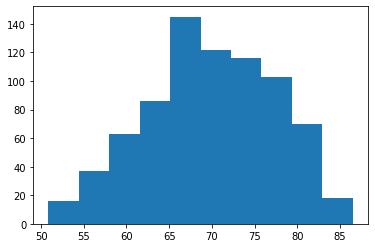

In [ ]:


# Note: They said no outliers were introduced in x_test so no need to perform outlier detection
y_pred = pipe.predict(x_test)
plt.hist(y_pred)

y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
y_pred_pd.to_csv('../../Predictions/mutual_info_LassoLarsCV_tree_boost.csv', index_label='id')

In [ ]:
pipe.named_steps

{'dimensionality reduction': FeatureAgglomeration(n_clusters=400),
 'feature_selection1': SelectKBest(k=50,
             score_func=<function mutual_info_regression at 0x7f8a4763f400>),
 'regressor': GradientBoostingRegressor()}